#### Import libraries and packages

In [6]:
import psycopg2
import psycopg2.extras as extras
import pandas as pd
import numpy as np
import seaborn as sns
from difflib import SequenceMatcher

#### Set connection with postgres database

In [2]:
host = 'postgresfib.fib.upc.edu'
dbname = 'ADSDBjordi.cluet'
user = 'jordi.cluet'
pwd = 'DB151199'
port = 6433
sslmode = 'require'

conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, user, pwd))
cursor = conn.cursor()

#### Get dataframe from exploitation zone

In [52]:
sql = "SELECT * from exploitation_zone.housing_view;"
df = pd.read_sql_query(sql, conn)

In [53]:
df

,id,bathrooms,building_subtype,conservation_state,discount,floor_elevator,price,rooms,sq_meters,neighbourhood,...,agressio_sex,conviv_veinal,vigilancia_poli,molesties_espai_pub,contra_prop_priv,incendis,estupefaents,agressions,proves_alcohol,proves_droga
0,1,1,Flat,Nearly new,0,True,1250.0,3,93.0,Sant Antoni,...,32,11474,4721,4445,2178,793,451,477,3770,326
1,62,1,Flat,Good,0,False,1200.0,3,80.0,Sant Antoni,...,32,11474,4721,4445,2178,793,451,477,3770,326
2,359,2,Flat,Good,0,True,1200.0,4,125.0,Sant Antoni,...,32,11474,4721,4445,2178,793,451,477,3770,326
3,214,2,Attic,New construction,0,True,1800.0,2,155.0,Sant Antoni,...,32,11474,4721,4445,2178,793,451,477,3770,326
4,228,1,Flat,New construction,150,False,1100.0,4,80.0,Sant Antoni,...,32,11474,4721,4445,2178,793,451,477,3770,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9393,9023,1,Flat,New construction,45,False,780.0,3,72.0,la Font d'en Fargues,...,24,4784,3062,2827,663,349,195,262,1568,106
9394,10925,1,Flat,New construction,50,False,650.0,2,50.0,la Font d'en Fargues,...,24,4784,3062,2827,663,349,195,262,1568,106
9395,2389,1,Flat,New construction,50,True,850.0,3,65.0,la Vall d'Hebron,...,24,4784,3062,2827,663,349,195,262,1568,106
9396,5538,1,Flat,Good,0,True,775.0,3,75.0,la Vall d'Hebron,...,24,4784,3062,2827,663,349,195,262,1568,106


#### Feature engineering

##### Remove some variables that are not useful for our modelling

neighbourhood has too many levels for our modelling, price_per_sqm since it was computed from the target and discount as it does not seem logical to take it into account for modelling.

In [54]:
df.drop(['neighbourhood', 'price_per_sqm', 'discount'], axis=1, inplace=True)

##### Create dataframe without crime varibales for first model

In [173]:
df2 = df.iloc[:,1:]
df2

,bathrooms,building_subtype,conservation_state,floor_elevator,price,rooms,sq_meters,districte,superficie,poblacio,...,agressio_sex,conviv_veinal,vigilancia_poli,molesties_espai_pub,contra_prop_priv,incendis,estupefaents,agressions,proves_alcohol,proves_droga
0,1,Flat,Nearly new,True,1250.0,3,93.0,Eixample,746.4,270331,...,32,11474,4721,4445,2178,793,451,477,3770,326
1,1,Flat,Good,False,1200.0,3,80.0,Eixample,746.4,270331,...,32,11474,4721,4445,2178,793,451,477,3770,326
2,2,Flat,Good,True,1200.0,4,125.0,Eixample,746.4,270331,...,32,11474,4721,4445,2178,793,451,477,3770,326
3,2,Attic,New construction,True,1800.0,2,155.0,Eixample,746.4,270331,...,32,11474,4721,4445,2178,793,451,477,3770,326
4,1,Flat,New construction,False,1100.0,4,80.0,Eixample,746.4,270331,...,32,11474,4721,4445,2178,793,451,477,3770,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9393,1,Flat,New construction,False,780.0,3,72.0,Horta-Guinardó,1192.0,174447,...,24,4784,3062,2827,663,349,195,262,1568,106
9394,1,Flat,New construction,False,650.0,2,50.0,Horta-Guinardó,1192.0,174447,...,24,4784,3062,2827,663,349,195,262,1568,106
9395,1,Flat,New construction,True,850.0,3,65.0,Horta-Guinardó,1192.0,174447,...,24,4784,3062,2827,663,349,195,262,1568,106
9396,1,Flat,Good,True,775.0,3,75.0,Horta-Guinardó,1192.0,174447,...,24,4784,3062,2827,663,349,195,262,1568,106


In [176]:
df2.to_csv('df2.csv', index=False)

##### One-hot enconding of some variables

In [117]:
ohe_bs = pd.get_dummies(df2.building_subtype, prefix='bs')
ohe_cs = pd.get_dummies(df2.conservation_state, prefix='cs')
ohe_d = pd.get_dummies(df2.districte, prefix='d')
df2 = pd.concat([df2, ohe_bs, ohe_cs, ohe_d], axis=1)
df2.drop(['building_subtype', 'conservation_state', 'districte'], axis=1, inplace=True)
df2.columns

Index(['bathrooms', 'floor_elevator', 'price', 'rooms', 'sq_meters',
       'superficie', 'poblacio', 'furt', 'estafes', 'danys', 'rob_viol_intim',
       'rob_en_vehicle', 'rob_força', 'lesions', 'aprop_indeg', 'amenaces',
       'rob_de_vehicle', 'ocupacions', 'salut_pub', 'abusos_sex',
       'entrada_domicili', 'agressio_sex', 'conviv_veinal', 'vigilancia_poli',
       'molesties_espai_pub', 'contra_prop_priv', 'incendis', 'estupefaents',
       'agressions', 'proves_alcohol', 'proves_droga', 'bs_Apartment',
       'bs_Attic', 'bs_Duplex', 'bs_Flat', 'bs_GroundFloorWithGarden',
       'bs_House_Chalet', 'bs_Loft', 'bs_SemiDetached', 'bs_SemidetachedHouse',
       'bs_Study', 'cs_Good', 'cs_Nearly new', 'cs_New construction',
       'cs_Renovated', 'cs_To renovate', 'cs_Very good', 'd_Ciutat Vella',
       'd_Eixample', 'd_Gràcia', 'd_Horta-Guinardó', 'd_Les Corts',
       'd_Nou Barris', 'd_Sant Andreu', 'd_Sant Martí', 'd_Sants-Montjuïc',
       'd_Sarrià-Sant Gervasi'],
      dty

In [118]:
df2

,bathrooms,floor_elevator,price,rooms,sq_meters,superficie,poblacio,furt,estafes,danys,...,d_Ciutat Vella,d_Eixample,d_Gràcia,d_Horta-Guinardó,d_Les Corts,d_Nou Barris,d_Sant Andreu,d_Sant Martí,d_Sants-Montjuïc,d_Sarrià-Sant Gervasi
0,1,True,1250.0,3,93.0,746.4,270331,14157,3390,1714,...,0,1,0,0,0,0,0,0,0,0
1,1,False,1200.0,3,80.0,746.4,270331,14157,3390,1714,...,0,1,0,0,0,0,0,0,0,0
2,2,True,1200.0,4,125.0,746.4,270331,14157,3390,1714,...,0,1,0,0,0,0,0,0,0,0
3,2,True,1800.0,2,155.0,746.4,270331,14157,3390,1714,...,0,1,0,0,0,0,0,0,0,0
4,1,False,1100.0,4,80.0,746.4,270331,14157,3390,1714,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9393,1,False,780.0,3,72.0,1192.0,174447,2119,1528,1039,...,0,0,0,1,0,0,0,0,0,0
9394,1,False,650.0,2,50.0,1192.0,174447,2119,1528,1039,...,0,0,0,1,0,0,0,0,0,0
9395,1,True,850.0,3,65.0,1192.0,174447,2119,1528,1039,...,0,0,0,1,0,0,0,0,0,0
9396,1,True,775.0,3,75.0,1192.0,174447,2119,1528,1039,...,0,0,0,1,0,0,0,0,0,0


#### Divide between train and validation sets

In [125]:
X = df2.drop('price', axis=1)
y = df2['price']

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
print(len(X_train), len(y_train), len(X_val), len(y_val))

7518 7518 1880 1880


#### Modelling

In [177]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [178]:
clf = make_pipeline(StandardScaler(), SVR(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(gamma='auto'))])

In [179]:
clf.score(X_val, y_val)

0.0899753409979892

In [180]:
clf.predict(X_val)

array([1171.64316183, 1074.13427115, 1211.75312383, ..., 1190.78678421,
       1213.16624232, 1070.3635102 ])

---

In [134]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [136]:
reg.score(X_val, y_val)

0.5779942269756129

In [135]:
reg.predict(X_val)

array([1288.78369429,  684.54163651, 2533.213933  , ..., 1651.11460143,
       1294.56370435, 1369.63814936])

---

In [159]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=8)
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=8)

In [161]:
neigh.score(X_val, y_val)

0.5757711231714306

In [160]:
neigh.predict(X_val)

array([1059.375,  700.625, 2600.   , ..., 1268.75 , 1246.875, 1115.625])

---

In [183]:
# ! pip install rpy2

In [182]:
%load_ext rpy2.ipython

C:\Users\jordi\anaconda3\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


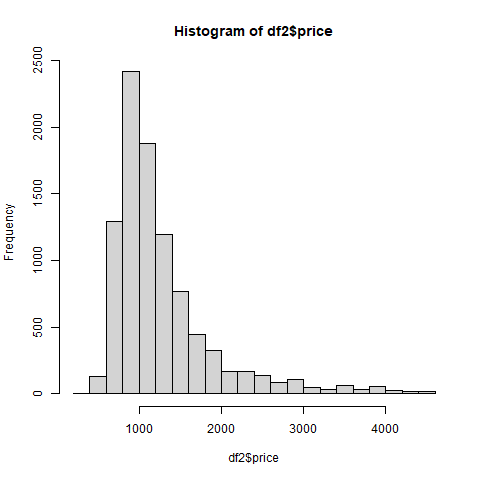

In [188]:
%%R
df2 = read.csv("df2.csv")
hist(df2$price)

In [ ]:
%%R
df2

     bathrooms      building_subtype conservation_state floor_elevator price
1            1                  Flat         Nearly new           True  1250
2            1                  Flat               Good          False  1200
3            2                  Flat               Good           True  1200
4            2                 Attic   New construction           True  1800
5            1                  Flat   New construction          False  1100
6            1                  Flat   New construction           True  1050
7            1                  Flat          Very good           True  1200
8            2                 Attic   New construction           True  2500
9            2                  Flat         Nearly new           True  1400
10           1                  Flat         Nearly new           True   800
11           1                 Attic   New construction           True  1050
12           1                  Flat               Good           True   990

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



                  Flat   New construction          False  2900
748          2                  Flat   New construction           True  1300
749          1                  Loft   New construction           True  1150
750          2                  Flat         Nearly new           True  2000
751          1                  Flat         Nearly new           True  1350
752          1             Apartment          Very good           True  1000
753          2                  Flat   New construction           True  1350
754          1                  Flat   New construction           True   900
755          1                 Attic   New construction           True  1175
756          1                  Flat   New construction           True  1300
757          2             Apartment   New construction          False  1300
758          2                  Flat   New construction           True  1200
759          2                  Flat          Very good           True  1500
760          